In [ ]:



import pandas as pd
import numpy as np

from scipy import stats
import math

from mplsoccer import PyPizza, add_image, FontManager
import matplotlib.pyplot as plt

In [ ]:
#import csv of Serie A stats from fbref. I have uploaded the data but I changed the column names in the csv prior.
df = pd.read_csv('/content/test2.csv')

#when you first read in the csv from fbref, you'll notice the player names are kind of weird. This code splits them on the \
df['Player'] = df['Player'].str.split('\\',expand=True)[0]

In [ ]:

df.head()

,Rk,Player,Nation,Pos,Squad,Age,Born,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,Tkl_1,Att,Tkl%,Past,Press,Succ,%,Def 3rd_2,Mid 3rd_3,Att 3rd_4,Blocks,Sh,ShSv,Pass,Int,Tkl+Int,Clr,Err,Matches
0,1.0,Gennaro Acampora,it ITA,MFFW,Spezia,26.0,1994.0,4.9,2.24,1.43,0.20,1.43,0.61,1.02,1.43,71.4,0.41,18.0,4.49,25.0,1.63,11.60,4.69,1.22,0.20,0.0,1.02,0.82,3.06,0.61,0.00,Matches
1,2.0,Francesco Acerbi,it ITA,DF,Lazio,32.0,1988.0,31.3,1.76,1.21,1.15,0.51,0.10,0.35,1.18,29.7,0.83,11.2,4.66,41.7,6.42,3.80,0.96,1.63,0.61,0.0,1.02,1.98,3.74,4.95,0.03,Matches
2,3.0,Andrea Adorante,it ITA,FW,Parma,20.0,2000.0,0.1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.00,30.0,10.00,33.3,0.00,10.00,20.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,Matches
3,4.0,Lucien Agoume,fr FRA,MF,Spezia,18.0,2002.0,8.9,1.57,1.24,1.01,0.56,0.00,0.22,1.46,15.4,1.24,17.0,4.83,28.5,5.73,9.66,1.57,2.02,0.45,0.0,1.57,2.25,3.82,1.57,0.11,Matches
4,5.0,Kevin Agudelo,co COL,FW,Spezia,21.0,1998.0,15.1,3.31,1.99,0.79,1.66,0.86,0.66,2.32,28.6,1.66,23.6,6.62,28.1,4.24,9.93,9.40,1.99,0.00,0.0,1.99,0.33,3.64,0.46,0.00,Matches


In [ ]:
# only defenders and only those with more than 15 90's played 
#(This data is from about week 35 so 12 90s will help us eliminate most outliers)
df = df.loc[(df['Pos']=='DF') & (df['90s']>15)]
#recheck the dataframe
df.columns

Index(['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', '90s', 'Tkl',
       'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Tkl_1', 'Att', 'Tkl%', 'Past',
       'Press', 'Succ', '%', 'Def 3rd_2', 'Mid 3rd_3', 'Att 3rd_4', 'Blocks',
       'Sh', 'ShSv', 'Pass', 'Int', 'Tkl+Int', 'Clr', 'Err', 'Matches'],
      dtype='object')

In [ ]:

# We now need to drop all of the columns that we don't want. 
# These are all the columns that won't be used included in the pizza plot
# These are just the ones I need to drop you may need to drop more or less depending on what you want to compare
df = df.drop(["Rk",'Nation','Pos','Squad','Age','Born','Matches', "Tkl%", '%'],axis=1).reset_index()

In [ ]:
df.isnull().values.any()

False

In [ ]:
df.head()


,index,Player,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,Tkl_1,Att,Past,Press,Succ,Def 3rd_2,Mid 3rd_3,Att 3rd_4,Blocks,Sh,ShSv,Pass,Int,Tkl+Int,Clr,Err
0,1,Francesco Acerbi,31.3,1.76,1.21,1.15,0.51,0.10,0.35,1.18,0.83,11.20,4.66,6.42,3.80,0.96,1.63,0.61,0.0,1.02,1.98,3.74,4.95,0.03
1,7,Bruno Alves,18.1,0.88,0.33,0.55,0.33,0.00,0.44,0.72,0.28,7.73,2.04,5.08,2.38,0.28,1.55,0.77,0.0,0.77,0.83,1.71,4.81,0.00
2,14,Cristian Ansaldi,21.6,2.22,1.20,1.11,0.74,0.37,1.20,1.90,0.69,12.10,3.75,5.32,3.89,2.92,1.48,0.32,0.0,1.16,1.25,3.47,1.25,0.05
3,21,Tommaso Augello,35.7,1.40,0.70,0.98,0.34,0.08,0.56,1.12,0.56,9.58,3.33,4.57,3.00,2.02,1.43,0.06,0.0,1.37,1.09,2.49,2.49,0.03
4,30,Federico Barba,29.5,1.15,0.68,0.81,0.27,0.07,0.34,0.81,0.47,10.20,3.08,5.86,3.53,0.78,1.76,0.61,0.0,1.15,1.93,3.08,3.97,0.14


In [ ]:
df.Player.unique()

array(['Francesco Acerbi', 'Bruno Alves', 'Cristian Ansaldi',
       'Tommaso Augello', 'Federico Barba', 'Alessandro Bastoni',
       'Simone Bastoni', 'Rodrigo BecÃ£o', 'Bartosz BereszyÅ„ski',
       'Cristiano Biraghi', 'Kevin Bonifazi', 'Leonardo Bonucci',
       'Gleison Bremer', 'MartÃ\xadn CÃ¡ceres', 'Davide Calabria',
       'Luca Caldirola', 'Federico Ceccherini', 'Luca Ceppitelli',
       'Julian Chabot', 'Giorgio Chiellini', 'Vlad ChiricheÈ™',
       'Omar Colley', 'Domenico Criscito', 'Danilo', 'PaweÅ‚ Dawidowicz',
       'Lorenzo De Silvestri', 'Giovanni Di Lorenzo', 'Mitchell Dijks',
       'Federico Dimarco', 'Koffi Djidji', 'Berat Djimsiti',
       'Martin Erlic', 'Davide Faraoni', 'Riccardo Gagliolo',
       'Kamil Glik', 'Diego GodÃ\xadn', 'Edoardo Goldaniga',
       'Vladimir GolemiÄ‡', 'Robin Gosens', 'Koray GÃ¼nter',
       'Achraf Hakimi', 'Hans Hateboer', 'Theo HernÃ¡ndez',
       'Elseid Hysaj', 'Roger Ibanez', 'Armando Izzo', 'Rick Karsdorp',
       'Giorgos Ki

In [ ]:

#Create a parameter list
params = list(df.columns)
params

['index',
 'Player',
 '90s',
 'Tkl',
 'TklW',
 'Def 3rd',
 'Mid 3rd',
 'Att 3rd',
 'Tkl_1',
 'Att',
 'Past',
 'Press',
 'Succ',
 'Def 3rd_2',
 'Mid 3rd_3',
 'Att 3rd_4',
 'Blocks',
 'Sh',
 'ShSv',
 'Pass',
 'Int',
 'Tkl+Int',
 'Clr',
 'Err']

In [ ]:
#drop the first 3 list item becuase we will not be using player,index, or 90s as a comparison metric
params = params[2:]

params

['90s',
 'Tkl',
 'TklW',
 'Def 3rd',
 'Mid 3rd',
 'Att 3rd',
 'Tkl_1',
 'Att',
 'Past',
 'Press',
 'Succ',
 'Def 3rd_2',
 'Mid 3rd_3',
 'Att 3rd_4',
 'Blocks',
 'Sh',
 'ShSv',
 'Pass',
 'Int',
 'Tkl+Int',
 'Clr',
 'Err']

In [ ]:
# Now we filter the df for the player we want. We will look at Cristian Romero. 
# The player needs to be spelled exactly the same way as it is in the data. Accents and everything.
player = df.loc[df['Player']=='Cristian Romero'].reset_index()
player = list(player.loc[0])
player = player[3:]
print(player)

[28.3, 2.65, 1.63, 1.77, 0.78, 0.11, 0.39, 1.41, 1.02, 17.2, 6.11, 7.99, 8.34, 0.85, 1.84, 0.49, 0.0, 1.34, 2.86, 5.51, 5.23, 0.07]


In [ ]:
player

[28.3,
 2.65,
 1.63,
 1.77,
 0.78,
 0.11,
 0.39,
 1.41,
 1.02,
 17.2,
 6.11,
 7.99,
 8.34,
 0.85,
 1.84,
 0.49,
 0.0,
 1.34,
 2.86,
 5.51,
 5.23,
 0.07]

In [ ]:
print(len(player),print(len(params)))

22
22 None


In [ ]:
# now that we have the player scores, we need to calculate the percentile values with scipy stats.

values = []
for x in range(len(params)):   
    values.append(math.floor(stats.percentileofscore(df[params[x]],player[x])))

In [ ]:
values

[72,
 92,
 94,
 95,
 87,
 52,
 22,
 58,
 82,
 99,
 100,
 95,
 100,
 44,
 65,
 46,
 39,
 68,
 99,
 100,
 84,
 80]

In [ ]:
for n,i in enumerate(values):
    if i == 100:
        values[n] = 99

In [ ]:
baker = PyPizza(
    params=params,                  # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)

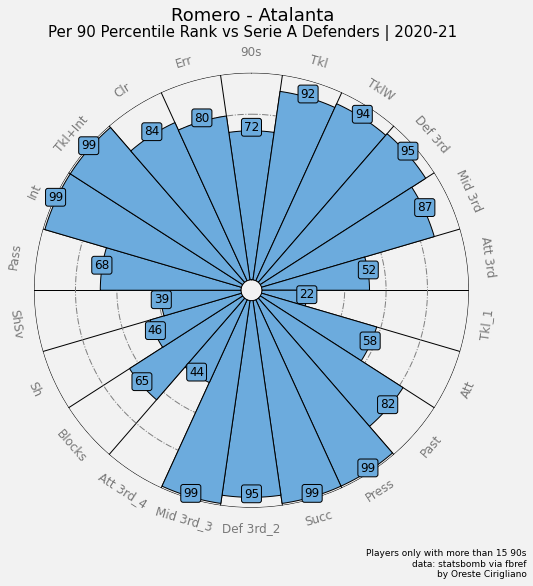

In [ ]:
fig, ax = baker.make_pizza(
    values,              # list of values
    figsize=(8, 8),      # adjust figsize according to your need
    param_location=110,  # where the parameters will be added
    kwargs_slices=dict(
        facecolor="#6CABDD", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        va="center", alpha=.5
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="#6CABDD",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

# add title
fig.text(
    0.515, 0.97, "Romero - Atalanta", size=18,
    ha="center", color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Per 90 Percentile Rank vs Serie A Defenders | 2020-21",
    size=15,
    ha="center", color="#000000"
)

# add credits
notes = 'Players only with more than 12 90s'
CREDIT_1 = "data: statsbomb via fbref"
CREDIT_2= "by Oreste Cirigliano"

fig.text(
    0.99, 0.005, f"{notes}\n{CREDIT_1}\n{CREDIT_2}", size=9,
    color="#000000",
    ha="right"
)

plt.savefig('pizza.png',dpi=500,bbox_inches = 'tight')